In [82]:

!pip install patchify
!pip3 install opencv-python
!pip install tensorflow



In [83]:


!pip install gradio
import os
import cv2
from PIL import Image # to convert the nd array back to image due to cv2f
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from matplotlib import pyplot as plt
import random
import gradio as gr

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.6.4 which is incompatible.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ---------------------------------------- 50.7/50.7 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/85.1 kB ? eta -:--:--
     -------------------------------------- - 81.9/85.1 kB 2.3 MB/s eta 0:00:01
     ---------------------------------------- 85.1/85.1 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/17.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/17.1 MB 4.5 MB/s eta 0:00:04
    --------------------------------------- 0.3/17.1 MB 3.9 MB/s eta 0:00:05
   - -------------------------------------- 0.5/17.1 MB 3.8 MB/s eta 0:00:05
   - -------------------------------------- 0.8/17.1 MB 4.1 MB/s eta 0:00:04
   -- ------------------------------------- 0.9/17.1 MB 4.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.2/17.1 MB 4.2

In [3]:
minmaxscaler=MinMaxScaler()

In [4]:


dataset_root_folder="Semantic segmentation dataset/"
# dataset_name="Semantic segmentation dataset/"
print(dataset_root_folder)


Semantic segmentation dataset/


In [5]:
# // This folder help to seperating folder , path, subdir in give folder

# fn=os.listdir("Semantic segmentation dataset")
# print(fn)

for path,subdirs,files in os.walk(dataset_root_folder):
  dir_name=path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name=='images':  # can have masks to masks images with formate .png
    images=os.listdir(path)
    print(path)
    # print(type(images)) here it'a array i will be traversing in it in future
    for i , image_name in enumerate(images):
      if(image_name.endswith(".jpg")):
        # print(image_name)
        a=True # because this variable just take account that image are here


Semantic segmentation dataset/Tile 1\images
Semantic segmentation dataset/Tile 2\images
Semantic segmentation dataset/Tile 3\images
Semantic segmentation dataset/Tile 4\images
Semantic segmentation dataset/Tile 5\images
Semantic segmentation dataset/Tile 6\images
Semantic segmentation dataset/Tile 7\images
Semantic segmentation dataset/Tile 8\images


In [6]:
image_patch_size=256

In [7]:
# now , we are going to read the image from image folder

image=cv2.imread(f'{dataset_root_folder}/Tile 1/images/image_part_001.jpg',1)



In [8]:
# cv2 convert this nd array
print(type(image))

<class 'numpy.ndarray'>


In [9]:
# a  Tile have the id and image_part have the id for that
image_dataset=[]
mask_dataset=[]
for image_type in ['images','masks']:
  if image_type=='images':
    image_extension='jpg' # png
  elif image_type=='masks':
    image_extension='png'
    # image_type='images' #,masks

  for tile_id in range(1,9):
    for image_id in range(1,30):
      image=cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      # valid the image is present or not by apply check
      if image is not None:
          if image_type=='masks':
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # because open cv read color in BGR while we will working on color as RGB
          # print(image.shape) # transform in most important ***
          # // now, our target to make image multiple of patch size
          size_x=(image.shape[1]//image_patch_size)*image_patch_size
          size_y=(image.shape[0]//image_patch_size)*image_patch_size
          # print(image.shape,"---->",size_x,size_y)
          # print(type(Image.fromarray(image))) #// here converting the nd array to image...
          image=(Image.fromarray(image)) #// here converting the nd array to image...
          # Now, our target to crop the image
          image=image.crop((0,0,size_x,size_y))
          # print(image.size[0],image.size[1])  # size because image has become an object
          image=np.array(image) # patchify function take numpy array as input

          patched_images=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size) # this function take numpy array as input
          # print(len(patched_images[1])) # no . of patch image created from single image
          # print(patched_images.shape) # *** This is most important to note here i am getting a array of no. of image_patch_size and using shape also proof that it's array
          # print(type(patched_images)) # numpy.ndarray
          # our task to take out our patched images from this numpy.ndarray
          # (2,3,1,256,256,3) // image is 1X256X256 in each array as matrix of 3 here 1 is no. or size of image
          for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
              if image_type=='images':
                individual_patched_image=patched_images[i,j,:,:]
                # print(individual_patched_image.shape)#[1,256, 256,3]
                #standard devitation tell how your value tend to closer to the average.
                #Normalization of dataset help us to manage the node size of modal so, modal
                #doesn't have inconsistency in it
                # for that i am minMax Scaler  this make every pixel of value of either
                #0 between  1.
                individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                # print(individual_patched_image.shape)
                individual_patched_image=individual_patched_image[0]
                # print(individual_patched_image.shape)
                image_dataset.append(individual_patched_image)
                  # print("run")
              elif image_type=='masks':
                # print("run1")

                individual_patched_mask=patched_images[i,j,:,:]
                individual_patched_mask=individual_patched_mask[0];
                # print(individual_patched_mask) # we does not need to fittransform the on mask images
                mask_dataset.append(individual_patched_mask)


              # final all the processedImages(batched of 256X256 image ) with normalised value is store in arr
              #It time to process the mask image






In [10]:
# here, i am confirming that the all data is numpy array which is already numpy but for being on safer side
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)
# print(type(mask_dataset))

In [11]:

print(len(image_dataset))
print(len(mask_dataset))


1305
1305


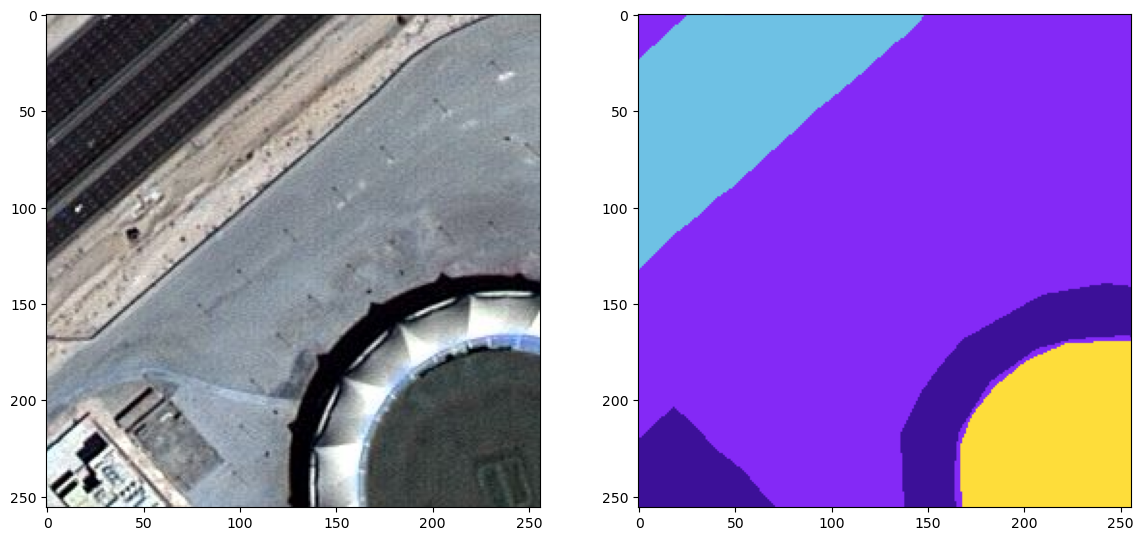

In [12]:
# for show image i am using matplotlib
image_dataset[0].shape #256,256,3
# how to show side by side
plt.figure(figsize=(14,8))
plt.subplot(121)
#random image
random_image_id=random.randint(0,len(image_dataset))


plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [13]:
# It time to generate one hot encoding for our labels
#one encoding allow us to represent the categories in number or other way is to use dummy variables
# first step to convert hex code to rgb
# here color are represent in the form of no.
# 3C 10 98 ---> index is 0,2,4 in array having 3C1098

# I want to create the tuple space of it continously so,
class_building='#3C1098'
class_building=class_building.lstrip('#')
class_building=tuple (int(class_building[i:i+2],16) for i in (0,2,4))
print(class_building)
class_land='#8429F6'
class_land=class_land.lstrip('#')
class_land=tuple (int(class_land[i:i+2],16) for i in (0,2,4))
print(class_land)

class_road='#6EC1E4'
class_road=class_road.lstrip('#')
class_road=tuple (int(class_road[i:i+2],16) for i in (0,2,4))
print(class_road)

class_vegetation='#FEDD3A'
class_vegetation=class_vegetation.lstrip('#')
class_vegetation=tuple (int(class_vegetation[i:i+2],16) for i in (0,2,4))
print(class_vegetation)

class_water='#E2A929'
class_water=class_water.lstrip('#')
class_water=tuple (int(class_water[i:i+2],16) for i in (0,2,4))
print(class_water)

class_unlabeled='#9B9B9B'
class_unlabeled=class_unlabeled.lstrip('#')
class_unlabeled=tuple (int(class_unlabeled[i:i+2],16) for i in (0,2,4))
print(class_unlabeled)

(60, 16, 152)
(132, 41, 246)
(110, 193, 228)
(254, 221, 58)
(226, 169, 41)
(155, 155, 155)


In [14]:
label=individual_patched_mask
# label of water is 1 here we are relating the quality with quantity which we type do in one hot encoding

In [15]:
def rgb_to_label(label):
  label_segment=np.zeros(label.shape,dtype=np.uint8)
  label_segment[np.all(label==class_water,axis=-1)]=0
  label_segment[np.all(label==class_land,axis=-1)]=1
  label_segment[np.all(label==class_road,axis=-1)]=2
  label_segment[np.all(label==class_building,axis=-1)]=3
  label_segment[np.all(label==class_vegetation,axis=-1)]=4
  label_segment[np.all(label==class_unlabeled,axis=-1)]=5
  label_segment=label_segment[:,:,0]

  print(label_segment.shape)
  # label_segment=1
  return label_segment

In [16]:
# now we need a method which take these rgb value convert them in 2Dlabels as  part on one hot encoding
labels=[]
for i in range(mask_dataset.shape[0]):
  label=rgb_to_label(mask_dataset[i])
  labels.append(label)


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

In [17]:
labels=np.array(labels)
print(len(labels))

1305


In [18]:
# labels[3]

In [19]:
labels=np.expand_dims(labels,axis=3)

In [20]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [21]:
# np.unique(labels)

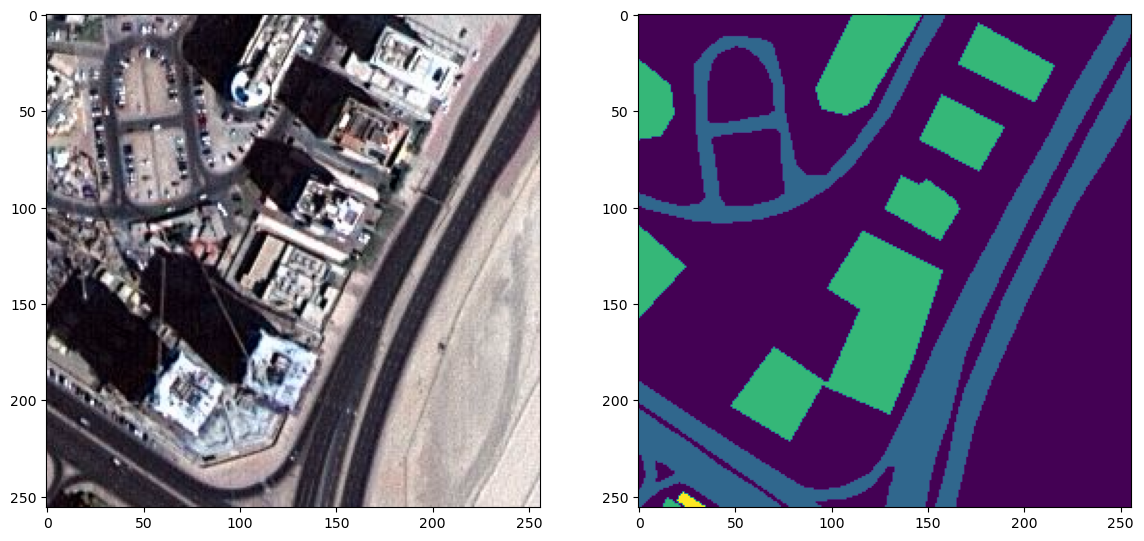

In [22]:

plt.figure(figsize=(14,8))
plt.subplot(121)
#random image
random_image_id=random.randint(0,len(image_dataset))

plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [23]:
labels[0][:,:,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [24]:

total_classes = len(np.unique(labels))

In [25]:

total_classes

6

In [26]:
from tensorflow.keras.utils import to_categorical

In [27]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)


In [28]:
# labels_categorical_dataset

In [29]:
labels_categorical_dataset.shape

(1305, 256, 256, 6)

In [30]:
master_trianing_dataset=image_dataset

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)


In [33]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1109, 256, 256, 3)
(196, 256, 256, 3)
(1109, 256, 256, 6)
(196, 256, 256, 6)


In [34]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [35]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [36]:
# 2 part above code is fine

In [37]:
!pip install -U segmentation_models

In [38]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda


In [39]:
import tensorflow.keras.backend as K

In [40]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten =tf.keras.layers.Flatten()(y_true)
  y_pred_flatten = tf.keras.layers.Flatten()(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [41]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model



In [42]:
metrics = ["accuracy", jaccard_coef]

In [43]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)


256
256
3
6


In [44]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)


In [45]:
model = get_deep_learning_model()

In [46]:
model.get_config()

{'name': 'functional_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bi

In [47]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [48]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [49]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [50]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [51]:
total_loss = dice_loss + (1 * focal_loss)

In [52]:

import tensorflow as tf

In [53]:
tf.keras.backend.clear_session()

In [54]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [55]:
# tf.keras.layers.Flatten()(input)

In [56]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:

model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.4036 - jaccard_coef: 0.1896 - loss: 1.0136 - val_accuracy: 0.6139 - val_jaccard_coef: 0.3430 - val_loss: 0.9931
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6384 - jaccard_coef: 0.3482 - loss: 0.9834 - val_accuracy: 0.7175 - val_jaccard_coef: 0.4554 - val_loss: 0.9615
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7146 - jaccard_coef: 0.4671 - loss: 0.9561 - val_accuracy: 0.6941 - val_jaccard_coef: 0.4594 - val_loss: 0.9639
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7333 - jaccard_coef: 0.4977 - loss: 0.9491 - val_accuracy: 0.7147 - val_jaccard_coef: 0.4805 - val_loss: 0.9586
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7449 - jaccard_coef: 0.5140 - loss: 0.9450 - val_accuracy: 0.7279 - val_jaccard_coef: 0.4943 - val_loss: 0.9564
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7612 - jaccard_coef: 0.5361 - loss: 0.9398 - val_a

In [58]:
history_a=model_history

In [59]:
history_a.history

{'accuracy': [0.5072376132011414,
  0.6711283326148987,
  0.7320660948753357,
  0.7426866888999939,
  0.758914589881897,
  0.7742131352424622,
  0.7900527715682983,
  0.8054473400115967,
  0.8083351254463196,
  0.820001482963562],
 'jaccard_coef': [0.26710182428359985,
  0.39260268211364746,
  0.4900749623775482,
  0.5108736157417297,
  0.5359367728233337,
  0.5587303638458252,
  0.5829049944877625,
  0.6070104837417603,
  0.6120662093162537,
  0.6325808763504028],
 'loss': [1.0007236003875732,
  0.975083589553833,
  0.95220947265625,
  0.947719156742096,
  0.9424048066139221,
  0.9376471638679504,
  0.9332641363143921,
  0.9280511140823364,
  0.9267163872718811,
  0.9221270084381104],
 'val_accuracy': [0.6139014363288879,
  0.7175447344779968,
  0.6940683722496033,
  0.7146879434585571,
  0.727870762348175,
  0.7396619319915771,
  0.774651050567627,
  0.7880387306213379,
  0.7935742139816284,
  0.8103999495506287],
 'val_jaccard_coef': [0.3430052101612091,
  0.45538023114204407,
  0.4

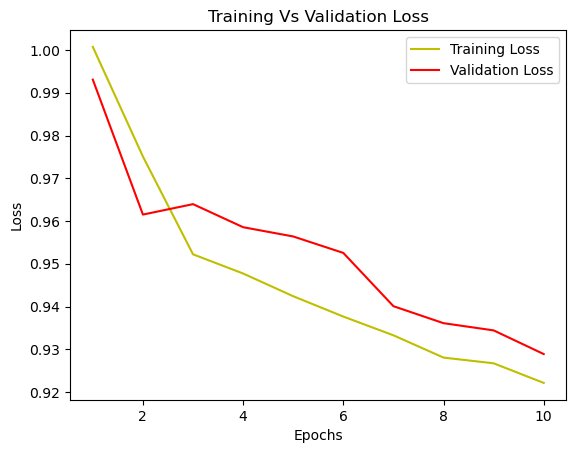

In [60]:

loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


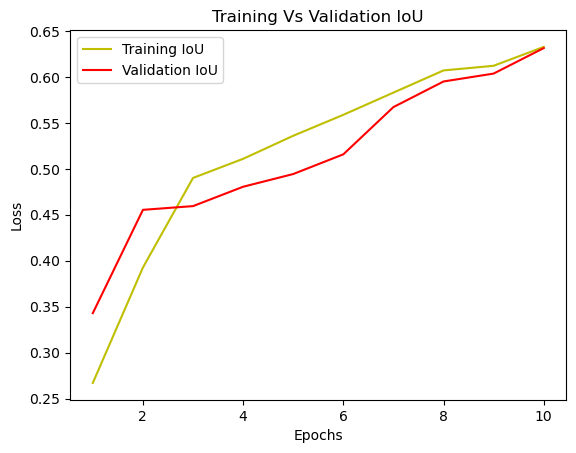

In [62]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
model_history.params


{'verbose': 1, 'epochs': 10, 'steps': 70}

In [66]:

y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 854ms/step


In [67]:
len(y_pred)


196

In [68]:
y_pred


array([[[[3.22782397e-02, 5.70589006e-01, 1.20309778e-01,
          9.52035040e-02, 5.54312021e-02, 1.26188233e-01],
         [1.04759233e-02, 7.50618696e-01, 1.05212338e-01,
          5.26750199e-02, 2.65477970e-02, 5.44703379e-02],
         [7.58100767e-03, 7.93612778e-01, 9.89730582e-02,
          3.89021970e-02, 1.83048248e-02, 4.26260754e-02],
         ...,
         [2.21150182e-03, 8.94155383e-01, 6.02761582e-02,
          2.05239579e-02, 5.98318735e-03, 1.68497730e-02],
         [4.75220336e-03, 8.35697293e-01, 8.51658732e-02,
          2.98149716e-02, 1.25779342e-02, 3.19917686e-02],
         [2.47835722e-02, 6.32336915e-01, 1.49134055e-01,
          6.99124858e-02, 5.09345643e-02, 7.28984922e-02]],

        [[2.36800741e-02, 7.36810982e-01, 8.69688690e-02,
          5.31248078e-02, 1.36877010e-02, 8.57275501e-02],
         [3.90443439e-03, 8.97559762e-01, 4.34363112e-02,
          2.16509718e-02, 4.52086469e-03, 2.89276801e-02],
         [2.51726341e-03, 9.39614534e-01, 3.1027

In [70]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [71]:

len(y_pred_argmax)

196

In [72]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 3, 3, 1],
        [1, 1, 1, ..., 3, 3, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[4, 4, 4, ..., 3, 3, 3],
        [4, 4, 4, ..., 3, 3, 3],
        [4, 4, 4, ..., 3, 3, 3],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[4, 4, 2, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 2, ..., 1, 1, 1],
        ...,
        [4, 2, 2, ..., 1, 1, 1],
        [4, 4, 2, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 

In [73]:
y_test_argmax = np.argmax(y_test, axis=3)



In [74]:
y_test_argmax


array([[[1, 1, 3, ..., 1, 1, 1],
        [1, 1, 3, ..., 1, 1, 1],
        [1, 1, 3, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1]],

       [[1, 2, 2, ..., 1, 1, 1],
        [1, 2, 2, ..., 1, 1, 2],
        [1, 2, 2, ..., 1, 2, 2],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        ...,
        [2, 2, 2, ..., 

In [75]:
#comparing prediction results

In [76]:
import random


In [77]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


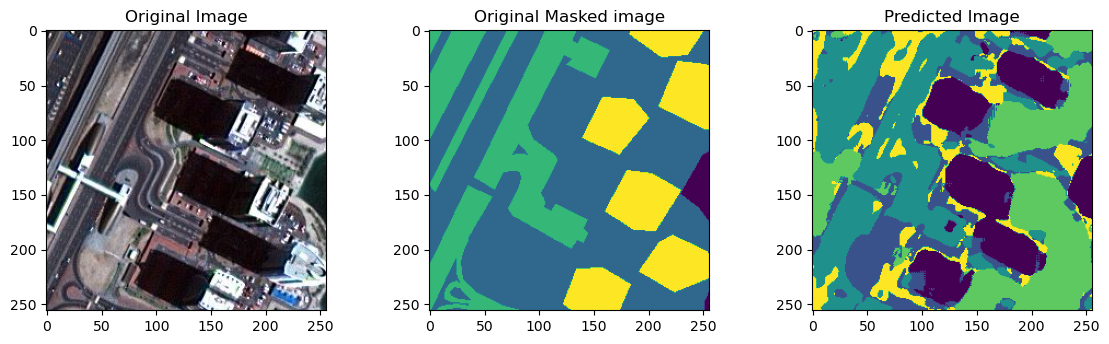

In [79]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)



In [80]:
model.save("satellite_segmentation_full.h5")

In [176]:
def process_input_image(image_source):
    # image_out=image_source
    # return "message",image_out
    # image=np.expand(prediction ,axis=3)
    # predicted_image=np.argmax(predicti
    image=np.expand_dims(image_source,0)
    prediction =satellite_model.predict(image)
    predicted_image=np.argmax(prediction,axis=3)
    predicted_image=predicted_image[0,:,:]
    print(predicted_image)
    predicted_image=predicted_image*50
    return 'Predicted Masked Image',predicted_image

In [177]:
my_app=gr.Blocks()

In [179]:
with my_app:
  gr.Markdown("Image Processing Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
        with gr.Row():
            with gr.Column():
                img_source = gr.Image(label="Please select source image",shape=(256,256))
                source_image_loader = gr.Button("Load above Image")
            with gr.Column():
                output_label = gr.Label(label="Image Info")
                img_output = gr.Image(label="Image Output")

    source_image_loader.click(
            process_input_image,
            [
                img_source
            ],
            [
                output_label,
                img_output
            ]
        )

            

In [180]:
my_app.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\gaura\anaconda3\Lib\site-packages\gradio\queueing.py", line 522, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gaura\anaconda3\Lib\site-packages\gradio\route_utils.py", line 260, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gaura\anaconda3\Lib\site-packages\gradio\blocks.py", line 1741, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gaura\anaconda3\Lib\site-packages\gradio\blocks.py", line 1296, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gaura\anaconda3\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^^^^^^^^^^^^^^^^^^